In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

In [32]:

df = pd.read_csv("fetal_health.csv")


In [33]:

X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy().astype(int)


In [34]:

print("Original Class Distribution:", Counter(y))


smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


y_resampled = y_resampled.astype(int)


print("After SMOTE Class Distribution:", Counter(y_resampled))


Original Class Distribution: Counter({1: 1655, 2: 295, 3: 176})
After SMOTE Class Distribution: Counter({2: 1655, 1: 1655, 3: 1655})


In [35]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [36]:
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [37]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

k=3 -> Validation Loss: 0.6243
k=5 -> Validation Loss: 0.4645
k=7 -> Validation Loss: 0.3457
k=9 -> Validation Loss: 0.2725
k=11 -> Validation Loss: 0.2373
k=13 -> Validation Loss: 0.2446
k=15 -> Validation Loss: 0.2093
k=17 -> Validation Loss: 0.2155
k=19 -> Validation Loss: 0.2218
k=21 -> Validation Loss: 0.2266
k=23 -> Validation Loss: 0.2314
k=25 -> Validation Loss: 0.2380
k=27 -> Validation Loss: 0.2432
k=29 -> Validation Loss: 0.2493
k=31 -> Validation Loss: 0.1737
k=33 -> Validation Loss: 0.1768


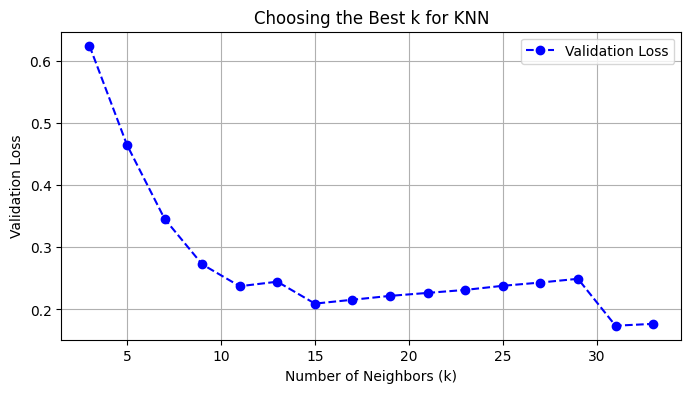

✅ Best k Found: 31


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import log_loss

class ManualKNN:
    def __init__(self, k=7):
        self.k = k
        self.classes_ = None

    def fit(self, X, y):
        """Stores training data and class labels."""
        self.X_train = X
        self.y_train = y
        self.classes_ = sorted(set(y))  # Ensure consistent class order

    def _compute_distance(self, x1, x2):
        """Compute Euclidean distance between two points."""
        return np.linalg.norm(x1 - x2)

    def predict(self, X):
        """Predict class labels for given X based on majority voting."""
        probabilities = self.predict_proba(X)
        return np.array([self.classes_[np.argmax(probs)] for probs in probabilities])  # Select class with max probability

    def predict_proba(self, X):
        """Predict class probabilities using distance-weighted voting."""
        probabilities = []
        for x in X:
            distances = np.array([self._compute_distance(x, x_train) for x_train in self.X_train])
            k_neighbors = np.argsort(distances)[:self.k]  # Get indices of k-nearest neighbors
            labels = [self.y_train[i] for i in k_neighbors]

            # **Weighted Probabilities**
            weights = 1 / (distances[k_neighbors] + 1e-6)  # Reduce epsilon to avoid instability
            label_weights = Counter()
            for label, weight in zip(labels, weights):
                label_weights[label] += weight

            total_weight = sum(label_weights.values())
            prob_distribution = {label: weight / total_weight for label, weight in label_weights.items()}

            # Convert to correct class order
            prob_vector = [prob_distribution.get(cls, 0) for cls in self.classes_]
            probabilities.append(prob_vector)

        return np.array(probabilities)

# Function to select best k using validation loss
def find_best_k(X_train, y_train, X_val, y_val):
    best_k = None
    best_val_loss = float("inf")
    k_values = list(range(3, 35, 2))  # Use only **odd values** to avoid tie issues

    validation_losses = []
    for k in k_values:
        knn = ManualKNN(k=k)
        knn.fit(X_train, y_train)

        y_val_pred = knn.predict_proba(X_val)
        val_loss = log_loss(y_val, y_val_pred)
        validation_losses.append(val_loss)

        print(f"k={k} -> Validation Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_k = k

    # **Plot k vs Validation Loss**
    plt.figure(figsize=(8, 4))
    plt.plot(k_values, validation_losses, marker='o', linestyle='dashed', color='b', label="Validation Loss")
    plt.xlabel("Number of Neighbors (k)")
    plt.ylabel("Validation Loss")
    plt.title("Choosing the Best k for KNN")
    plt.legend()
    plt.grid()
    plt.show()

    print(f"✅ Best k Found: {best_k}")
    return best_k

# Find best k
best_k = find_best_k(X_train_scaled, y_train, X_val_scaled, y_val)


In [39]:

models = {

    "KNN": ManualKNN(k=best_k)

}



KNN
Train Accuracy: 99.97%
Validation Accuracy: 93.21%
Test Accuracy: 90.94%
Validation Loss (Log Loss): 0.1737
Test Loss (Log Loss): 0.2525
              precision    recall  f1-score   support

           1       0.98      0.82      0.89       353
           2       0.82      0.97      0.88       317
           3       0.96      0.95      0.96       323

    accuracy                           0.91       993
   macro avg       0.92      0.91      0.91       993
weighted avg       0.92      0.91      0.91       993



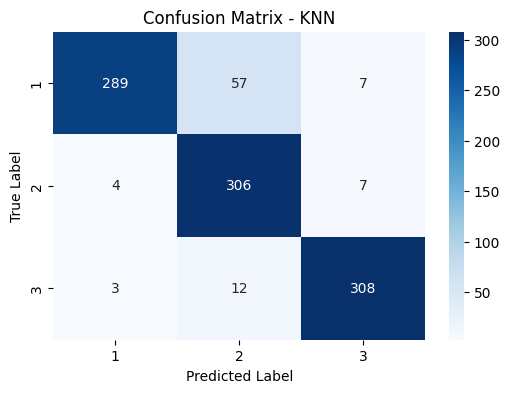

In [40]:
# Store predictions
predictions = {}

# Train and evaluate models
for name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Predict on Training Set
    y_train_pred = model.predict(X_train_scaled)
    train_acc = accuracy_score(y_train, y_train_pred) * 100

    # Predict on Validation Set
    y_val_pred = model.predict_proba(X_val_scaled)  # Use scaled validation data
    val_loss = log_loss(y_val, y_val_pred)
    y_val_class_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, y_val_class_pred) * 100  # Validation accuracy

    # Predict on Test Set
    y_test_pred = model.predict_proba(X_test_scaled)  # Use scaled test data
    test_loss = log_loss(y_test, y_test_pred)
    y_test_class_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, y_test_class_pred) * 100  # Test accuracy

    predictions[name] = y_test_class_pred

    # Print Metrics
    print(f"\n{name}")
    print(f"Train Accuracy: {train_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(f"Validation Loss (Log Loss): {val_loss:.4f}")
    print(f"Test Loss (Log Loss): {test_loss:.4f}")
    print(classification_report(y_test, y_test_class_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_class_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()
